Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:27<00:00, 220MB/s]
100% 2.29G/2.29G [00:27<00:00, 88.3MB/s]
Device: cuda


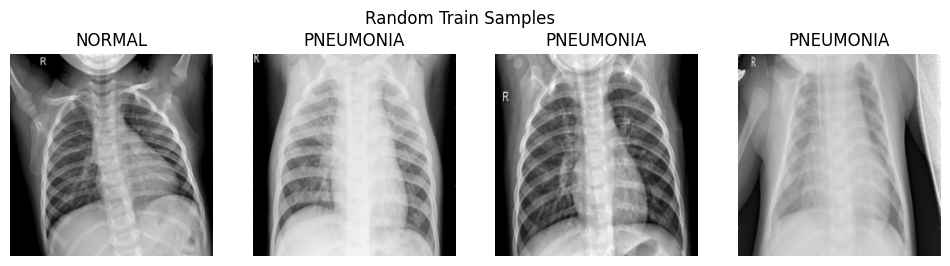

100%|██████████| 163/163 [01:18<00:00,  2.09it/s]


Epoch 1: Train Loss=0.3338, Train Acc=0.8696 | Val Loss=1.2507, Val Acc=0.6250


100%|██████████| 163/163 [01:17<00:00,  2.11it/s]


Epoch 2: Train Loss=0.1830, Train Acc=0.9346 | Val Loss=0.2711, Val Acc=0.8125


100%|██████████| 163/163 [01:17<00:00,  2.11it/s]


Epoch 3: Train Loss=0.1384, Train Acc=0.9507 | Val Loss=1.6208, Val Acc=0.5625


100%|██████████| 163/163 [01:17<00:00,  2.10it/s]


Epoch 4: Train Loss=0.1071, Train Acc=0.9634 | Val Loss=0.1708, Val Acc=0.9375


100%|██████████| 163/163 [01:17<00:00,  2.10it/s]


Epoch 5: Train Loss=0.0956, Train Acc=0.9655 | Val Loss=0.8238, Val Acc=0.7500


100%|██████████| 163/163 [01:18<00:00,  2.07it/s]


Epoch 6: Train Loss=0.0860, Train Acc=0.9711 | Val Loss=0.3792, Val Acc=0.8750


100%|██████████| 163/163 [01:18<00:00,  2.08it/s]


Epoch 7: Train Loss=0.0681, Train Acc=0.9766 | Val Loss=0.1051, Val Acc=1.0000


100%|██████████| 163/163 [01:18<00:00,  2.07it/s]


Epoch 8: Train Loss=0.0639, Train Acc=0.9770 | Val Loss=0.9058, Val Acc=0.7500


100%|██████████| 163/163 [01:18<00:00,  2.08it/s]


Epoch 9: Train Loss=0.0656, Train Acc=0.9766 | Val Loss=0.4629, Val Acc=0.8750


100%|██████████| 163/163 [01:18<00:00,  2.08it/s]


Epoch 10: Train Loss=0.0420, Train Acc=0.9868 | Val Loss=0.2063, Val Acc=0.8750


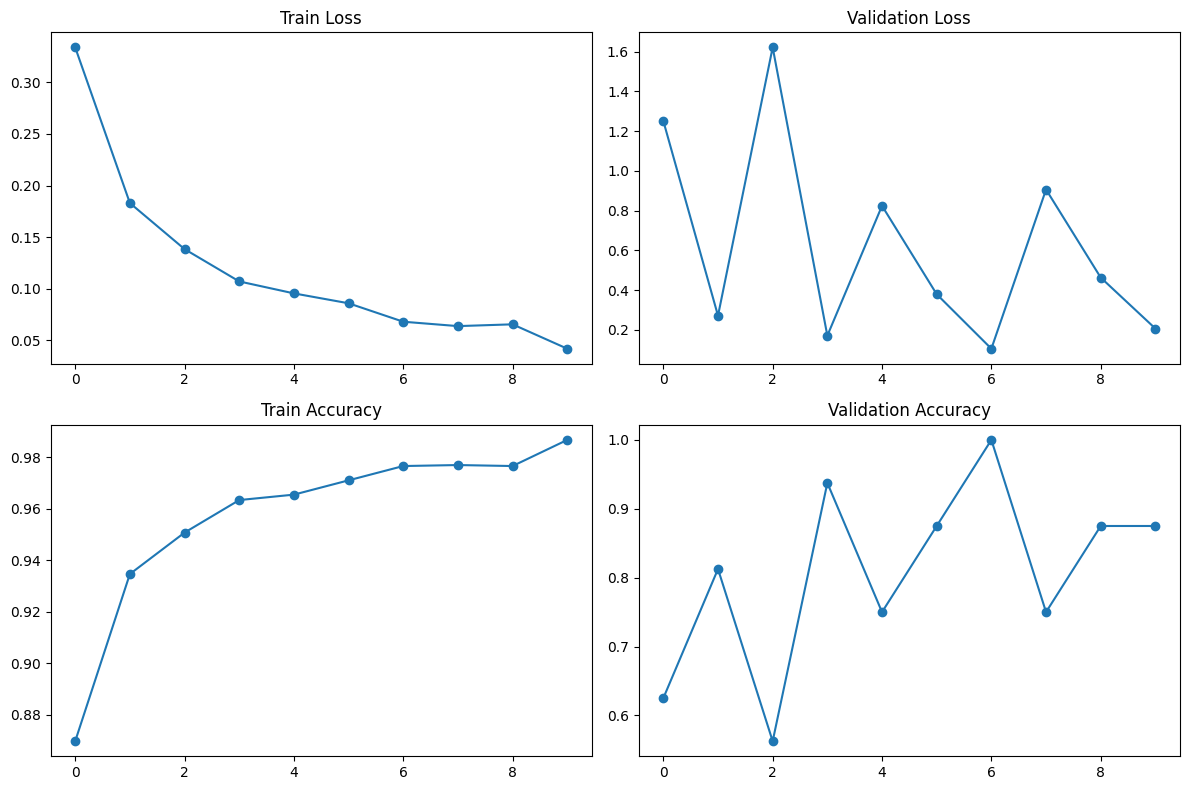

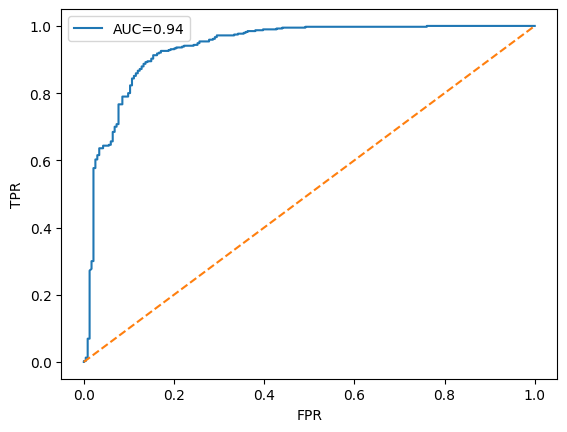

Best threshold: 0.9821776


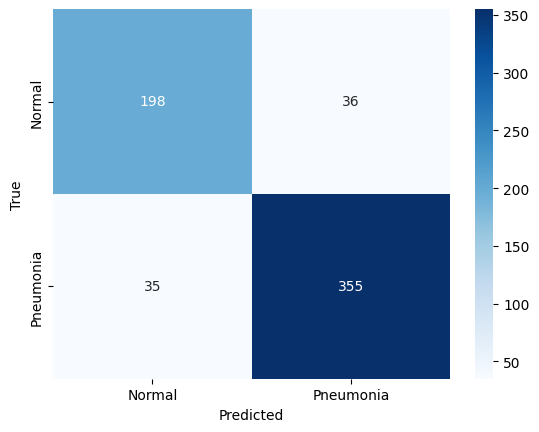

              precision    recall  f1-score   support

      Normal       0.85      0.85      0.85       234
   Pneumonia       0.91      0.91      0.91       390

    accuracy                           0.89       624
   macro avg       0.88      0.88      0.88       624
weighted avg       0.89      0.89      0.89       624



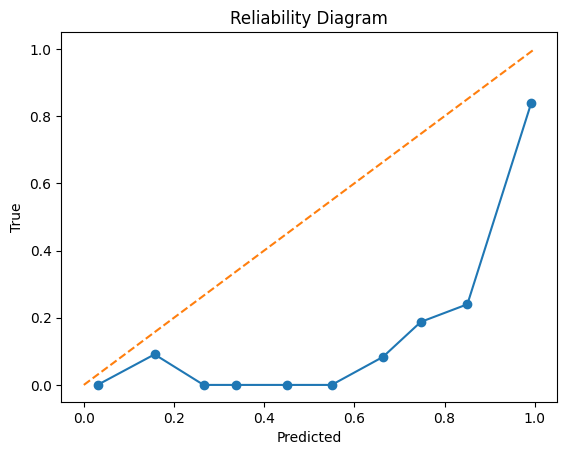

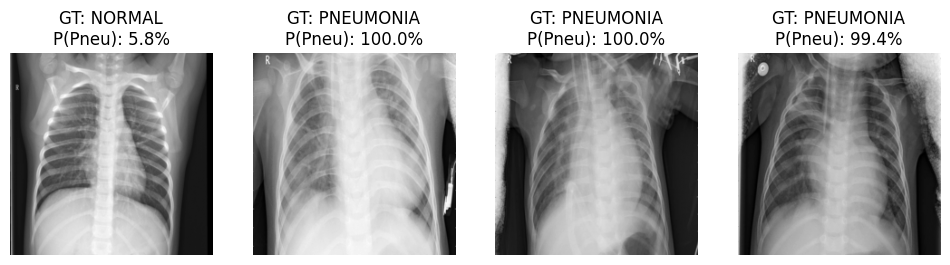

In [1]:
!pip install -q torch torchvision scikit-learn matplotlib seaborn kaggle tqdm

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

import os

DATA_DIR = "/content/data"
os.makedirs(DATA_DIR, exist_ok=True)

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p {DATA_DIR}
!unzip -q {DATA_DIR}/chest-xray-pneumonia.zip -d {DATA_DIR}

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.calibration import calibration_curve

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# =========================
# Data transforms
# =========================
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])

train_ds = datasets.ImageFolder(f"{DATA_DIR}/chest_xray/train", train_transform)
val_ds   = datasets.ImageFolder(f"{DATA_DIR}/chest_xray/val", val_transform)
test_ds  = datasets.ImageFolder(f"{DATA_DIR}/chest_xray/test", val_transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=32, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=32, num_workers=2)

# =========================
# Utils
# =========================
def denormalize(img):
    mean = torch.tensor([0.485]).view(1,1,1)
    std  = torch.tensor([0.229]).view(1,1,1)
    return img * std + mean

def show_random_samples(dataset, n=4, title="Samples"):
    idxs = random.sample(range(len(dataset)), n)
    fig, axs = plt.subplots(1, n, figsize=(3*n,3))

    for ax, idx in zip(axs, idxs):
        img, label = dataset[idx]
        img = denormalize(img).clamp(0,1)
        ax.imshow(img[0], cmap="gray")
        ax.set_title(dataset.classes[label])
        ax.axis("off")

    fig.suptitle(title)
    plt.show()

show_random_samples(train_ds, title="Random Train Samples")

# =========================
# Deep CNN
# =========================
class DeepCNN(nn.Module):
    def __init__(self):
        super().__init__()

        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),

                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),

                nn.MaxPool2d(2)
            )

        self.features = nn.Sequential(
            block(1, 32),
            block(32, 64),
            block(64, 128),
            block(128, 256),
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

model = DeepCNN().to(device)

# =========================
# Training setup
# =========================
class_counts = np.bincount(train_ds.targets)
weights = 1. / torch.tensor(class_counts, dtype=torch.float)
weights = (weights / weights.sum()).to(device)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-4)

def train_epoch(loader):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for x, y in tqdm(loader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    return total_loss / len(loader), correct / total

def eval_epoch(loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)

            total_loss += loss.item()
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

    return total_loss / len(loader), correct / total

# =========================
# Train
# =========================
EPOCHS = 10

train_losses, train_accs = [], []
val_losses, val_accs = [], []

for e in range(EPOCHS):
    tl, ta = train_epoch(train_loader)
    vl, va = eval_epoch(val_loader)

    train_losses.append(tl)
    train_accs.append(ta)
    val_losses.append(vl)
    val_accs.append(va)

    print(f"Epoch {e+1}: "
          f"Train Loss={tl:.4f}, Train Acc={ta:.4f} | "
          f"Val Loss={vl:.4f}, Val Acc={va:.4f}")

# =========================
# Curves
# =========================
plt.figure(figsize=(12,8))
plt.subplot(2,2,1); plt.plot(train_losses,'-o'); plt.title("Train Loss")
plt.subplot(2,2,2); plt.plot(val_losses,'-o'); plt.title("Validation Loss")
plt.subplot(2,2,3); plt.plot(train_accs,'-o'); plt.title("Train Accuracy")
plt.subplot(2,2,4); plt.plot(val_accs,'-o'); plt.title("Validation Accuracy")
plt.tight_layout()
plt.show()

# =========================
# Test & Evaluation
# =========================
model.eval()
y_true, y_prob = [], []

with torch.no_grad():
    for x, y in test_loader:
        p = torch.softmax(model(x.to(device)),1)[:,1]
        y_true.extend(y.numpy())
        y_prob.extend(p.cpu().numpy())

fpr, tpr, thr = roc_curve(y_true, y_prob)
best_thr = thr[(tpr - fpr).argmax()]
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC={roc_auc:.2f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.legend(); plt.show()

print("Best threshold:", best_thr)

y_pred = (np.array(y_prob) > best_thr).astype(int)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=["Normal","Pneumonia"],
            yticklabels=["Normal","Pneumonia"],
            cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

print(classification_report(
    y_true, y_pred,
    target_names=["Normal","Pneumonia"]
))

pt, pp = calibration_curve(y_true, y_prob, n_bins=10)

plt.plot(pp, pt, marker='o')
plt.plot([0,1],[0,1],'--')
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Reliability Diagram")
plt.show()

# =========================
# Visual predictions
# =========================
def show_random_predictions(dataset, model, n=4):
    idxs = random.sample(range(len(dataset)), n)
    fig, axs = plt.subplots(1, n, figsize=(3*n,3))
    model.eval()

    for ax, idx in zip(axs, idxs):
        img, label = dataset[idx]
        img_dn = denormalize(img).clamp(0,1)

        with torch.no_grad():
            p = torch.softmax(
                model(img.unsqueeze(0).to(device)),1
            )[0,1].item()*100

        ax.imshow(img_dn[0], cmap="gray")
        ax.set_title(f"GT: {dataset.classes[label]}\nP(Pneu): {p:.1f}%")
        ax.axis("off")

    plt.show()

show_random_predictions(test_ds, model)

# =========================
# Save model
# =========================
torch.save(model.state_dict(), "deepcnn_pneumonia.pt")